In [28]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

pd.set_option('display.max_column', 500)
pd.set_option('display.max_rows', 5000)
random.seed(1001)
sns.set(font="Arial Unicode MS")

In [29]:
dftrain = pd.read_csv('X_train.csv' , index_col=0)
dftest = pd.read_csv('X_test.csv', index_col=0)
y_train_all = pd.read_csv('y_train.csv', index_col=0)

print(f"Training df shape = {dftrain.shape}; test df shape = {dftest.shape}")

Training df shape = (9460, 41); test df shape = (2366, 41)


In [30]:
# 把 建築完成年月 換算成 建築年齡
dftrain['建築年齡'] = dftrain['建築完成年月'].apply(lambda x: 
                        (datetime.now() - datetime.strptime(x, "%Y-%m-%d")).days / 365.25)

# 丟掉 建築完成年月
dftrain.drop(['建築完成年月'], axis=1, inplace=True)

dftest['建築年齡'] = dftest['建築完成年月'].apply(lambda x:
                        (datetime.now() - datetime.strptime(x, "%Y-%m-%d")).days / 365.25)

dftest.drop(['建築完成年月'], axis=1, inplace=True)

In [31]:
# 把 交易年	交易日 交易月 丟掉，變成有小數點的年份
dftrain['交易年'] = dftrain['交易年'] + dftrain['交易月'] / 12 + dftrain['交易日'] / 365.25
dftrain.drop(['交易日', '交易月'], axis=1, inplace=True)

dftest['交易年'] = dftest['交易年'] + dftest['交易月'] / 12 + dftest['交易日'] / 365.25
dftest.drop(['交易日', '交易月'], axis=1, inplace=True)

In [32]:
# 交易年 - min()
mini = dftrain['交易年'].min()
dftrain['交易年'] = dftrain['交易年'] - mini
dftest['交易年'] = dftest['交易年'] - mini

In [33]:
dftrain.head()

,鄉鎮市區,交易標的,路名,土地移轉總面積平方公尺,都市土地使用分區,土地數,建物數,車位數,移轉層次,移轉層次項目,總樓層數,建物型態,主要用途,主要建材,建物移轉總面積平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,建物現況格局-隔間,有無管理組織,交易年,地鐵站,超商,公園,托兒所,國小,國中,高中職,大學,金融機構,醫院,大賣場,超市,百貨公司,警察局,消防局,縱坐標,橫坐標,建築年齡
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,文山區,房地(土地+建物)+車位,興隆路三段,27.75,住,1.0,1.0,1.0,1,無,7.0,華廈(10層含以下有電梯),見其他登記事項,鋼筋混凝土造,133.43,3,2,2,有,有,7.382615,1.0,7.0,2.0,20.0,20.0,19.0,12.0,17.0,15.0,20.0,7.0,20.0,13.0,20.0,16.0,24.957269,121.588026,5.100616
1,中正區,房地(土地+建物),金山南路一段,9.57,第三種住宅區,1.0,1.0,0.0,5,無,6.0,華廈(10層含以下有電梯),住家用,鋼筋混凝土造,40.34,1,1,1,有,有,8.736311,1.0,12.0,8.0,20.0,20.0,20.0,13.0,20.0,20.0,20.0,13.0,20.0,20.0,20.0,20.0,24.997141,121.558262,27.255305
2,文山區,房地(土地+建物),秀明路一段,9.51,住,1.0,1.0,0.0,1,無,7.0,套房(1房1廳1衛),住家用,鋼筋混凝土造,70.61,1,1,1,有,有,8.043806,0.0,6.0,7.0,20.0,20.0,18.0,11.0,19.0,15.0,18.0,6.0,20.0,11.0,20.0,13.0,24.953906,121.601050,15.526352
3,內湖區,房地(土地+建物)+車位,康樂街,23.67,第三種住宅區,1.0,1.0,1.0,10,無,15.0,住宅大樓(11層含以上有電梯),見其他登記事項,鋼筋混凝土造,143.83,3,2,2,有,有,7.144764,1.0,12.0,14.0,20.0,20.0,14.0,5.0,4.0,19.0,20.0,12.0,20.0,13.0,20.0,15.0,25.008046,121.557424,15.578371
4,北投區,房地(土地+建物),公路,22.50,第三種住宅區,1.0,1.0,0.0,2,無,5.0,公寓(5樓含以下無電梯),住家用,鋼筋混凝土造,83.73,2,1,1,有,無,8.986311,2.0,4.0,13.0,20.0,20.0,15.0,5.0,15.0,19.0,20.0,10.0,20.0,16.0,18.0,13.0,24.986825,121.557424,51.764545


In [34]:
def gen_features(dftrain, dftest, numfeatures, catfeatures, encoder):
    # Combine train and test data for categorical features
    combined_cat = pd.concat([dftrain[catfeatures], dftest[catfeatures]])
    
    # Fit encoder on the combined data
    encoder.fit(combined_cat)
    
    # Transform training data
    X_train = dftrain[numfeatures].to_numpy()  # Numerical features
    X_train_cat = encoder.transform(dftrain[catfeatures]).toarray()  # Encoded categorical features
    X_train = np.hstack((X_train, X_train_cat))
    
    # Transform testing data
    X_test = dftest[numfeatures].to_numpy()  # Numerical features
    X_test_cat = encoder.transform(dftest[catfeatures]).toarray()  # Encoded categorical features
    X_test = np.hstack((X_test, X_test_cat))
    
    return X_train, X_test

In [35]:
#get the column names of dftrain
numfeatures = dftrain.select_dtypes(include=[np.number]).columns
print(f"Numerical features = {numfeatures}")
print(f"Number of numerical features = {len(numfeatures)}")
numfeatures = numfeatures.tolist()

# Update np.object to just 'object' in the dtype selection
catfeatures = dftrain.select_dtypes(include=['object']).columns
print(f"Categorical features = {catfeatures}")
print(f"Number of categorical features = {len(catfeatures)}")
catfeatures = catfeatures.tolist()

Numerical features = Index(['土地移轉總面積平方公尺', '土地數', '建物數', '車位數', '移轉層次', '總樓層數', '建物移轉總面積平方公尺',
       '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', '交易年', '地鐵站', '超商', '公園', '托兒所',
       '國小', '國中', '高中職', '大學', '金融機構', '醫院', '大賣場', '超市', '百貨公司', '警察局',
       '消防局', '縱坐標', '橫坐標', '建築年齡'],
      dtype='object')
Number of numerical features = 29
Categorical features = Index(['鄉鎮市區', '交易標的', '路名', '都市土地使用分區', '移轉層次項目', '建物型態', '主要用途', '主要建材',
       '建物現況格局-隔間', '有無管理組織'],
      dtype='object')
Number of categorical features = 10


In [36]:
X_train_all, X_test_all = gen_features(dftrain, dftest, numfeatures, catfeatures, OneHotEncoder())

print(f"X_train shape = {X_train_all.shape}; X_test shape = {X_test_all.shape}")

X_train shape = (9460, 741); X_test shape = (2366, 741)


In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=1001)

# Define the objective function for Optuna
def objective(trial):

    # 建議的超參數範圍
    n_estimators = trial.suggest_int('n_estimators', 500, 2000, step=100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)  # L1 正則化
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)  # L2 正則化
    gamma = trial.suggest_float('gamma', 0.0, 5.0)  # 用於控制樹的分裂

    # 初始化模型，應用建議的參數
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        gamma=gamma,
        random_state=1001,
        objective='reg:squarederror',  # 使用均方誤差作為目標
        tree_method='auto'  # 根據硬體情況自動選擇算法
    )
    
    
    # Fit the model
    xgb.fit(X_train, y_train.values.ravel())
    
    # Predict on the validation set
    y_pred = xgb.predict(X_val)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# Create an Optuna study and optimize

initial_params = {
    'n_estimators': 1500,
    'learning_rate': 0.041294277979478405,
    'max_depth': 11,
    'subsample': 0.6536986732227053,
    'colsample_bytree': 0.6770571495600126,
    'min_child_weight': 5,
    'reg_alpha': 0.7594404636329284,
    'reg_lambda': 0.00042606665458623055,
    'gamma': 0.6680461822789606
}

study = optuna.create_study(direction="minimize")
study.enqueue_trial(initial_params)
study.optimize(objective, n_trials=30, n_jobs=-1)
# Get the best parameters and validation RMSE
best_params = study.best_params
best_rmse = study.best_value

print(f"Best parameters: {best_params}")
print(f"Validation RMSE: {best_rmse}")


[I 2024-11-21 01:28:18,692] A new study created in memory with name: no-name-6c30690c-47a9-4bd0-9c6f-e73f772c89a3
[I 2024-11-21 01:28:33,839] Trial 5 finished with value: 33602.507154513325 and parameters: {'n_estimators': 900, 'learning_rate': 0.0997308174654643, 'max_depth': 4, 'subsample': 0.6198930970165231, 'colsample_bytree': 0.659507337381926, 'min_child_weight': 20, 'reg_alpha': 0.00017034587635817507, 'reg_lambda': 4.8350254757829384e-05, 'gamma': 3.8520254144160453}. Best is trial 5 with value: 33602.507154513325.
[I 2024-11-21 01:28:35,842] Trial 7 finished with value: 33133.65194989287 and parameters: {'n_estimators': 600, 'learning_rate': 0.04167795851313125, 'max_depth': 8, 'subsample': 0.8152275993919577, 'colsample_bytree': 0.8406995276142192, 'min_child_weight': 17, 'reg_alpha': 7.488861296973217e-08, 'reg_lambda': 0.0034647244590082383, 'gamma': 4.958799028376259}. Best is trial 7 with value: 33133.65194989287.
[I 2024-11-21 01:28:36,851] Trial 2 finished with value: 

Best parameters: {'n_estimators': 1500, 'learning_rate': 0.041294277979478405, 'max_depth': 11, 'subsample': 0.6536986732227053, 'colsample_bytree': 0.6770571495600126, 'min_child_weight': 5, 'reg_alpha': 0.7594404636329284, 'reg_lambda': 0.00042606665458623055, 'gamma': 0.6680461822789606}
Validation RMSE: 32418.572258500837


In [38]:
# Use the best parameters and the complete training data to train the model
final_model = XGBRegressor(**study.best_params, random_state=1001, objective='reg:squarederror')
final_model.fit(X_train_all, y_train_all.values.ravel())

#save the final_model
import pickle
with open('final_model_xgboost.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Predict on the test data
y_pred = final_model.predict(X_test_all)

In [ ]:
# Write the predictions to a CSV file
submission = pd.DataFrame({'單價元平方公尺': y_pred}, index=dftest.index)
#submission.to_csv('submission_xgboost_nofs.csv', index=True)

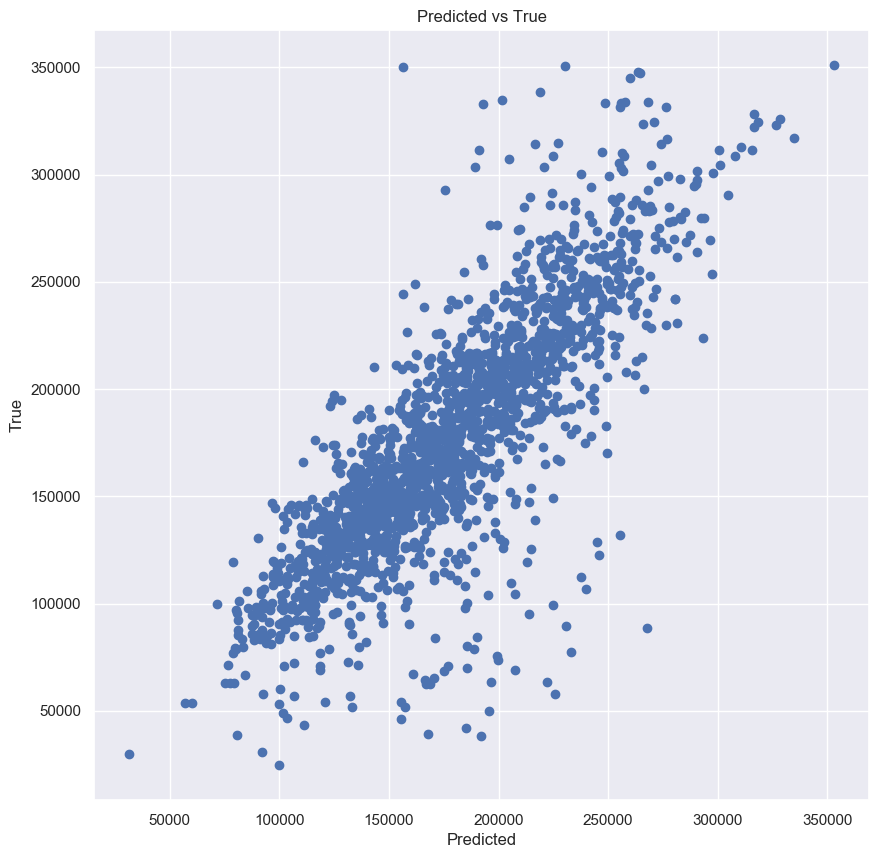

In [40]:
final_model.fit(X_train, y_train.values.ravel())

Y_val_pred = final_model.predict(X_val)

#plot the predicted value and the true value
plt.figure(figsize=(10, 10))
plt.scatter(Y_val_pred, y_val)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Predicted vs True')
plt.show()

In [43]:
#Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_val, Y_val_pred))
print(f"Validation RMSE: {rmse}")

Validation RMSE: 32418.572258500837
